# Test data

This notebook exemplifies what occurs when the clean data used as reference for the [EEG Quality Index](../Functions/eeg_quality_index.py) is not detrended or high-pass filtered. 

The issue occurs if the clean data has drift of DC offsets that cause the zero-crossing rate yield to 0 values. The Z-scores are then calculated as:
$$ \text{Z}_\text{score} = \frac{x-\mu}{\sigma} $$

Where $x$ is the value of the quality index metric (e.g., zero-crossing rate) of the test dataset for each window, and $\mu$ and $\sigma$ are the mean and standard deviation of the same quality index metric of the clean dataset. As seen in the equation, if the zero-crossing rate only hace 0's, the standard deviation $\sigma$ would be 0. Thus, we would divide by 0 and get a `NaN` value result.

To demonstrate this, we will take some "clean" data with a lot of DC offset and compute the EEG Quality Index. Then, we will apply a high-pass filter to eliminate the DC.

## Import libraries

In [50]:
# Open plots in separate interactive window
%matplotlib qt

# Import libraries
import os
import mne
import sys
import pyxdf
import numpy as np
import scipy.fft as fft
import scipy.stats as stats
sys.path.append("..") # Adds higher directory to python modules path.
from Functions import eeg_quality_index

Channels marked as bad:
['Fz']
Channels marked as bad:
none


## Import data

The clean dataset is in a `xdf` format which not native in MNE. Create an MNE object from the `xdf` data for easier plotting and filtering.

In [55]:
# Get data directory
current_directory = os.getcwd()
os.chdir("..")
data_folder = os.getcwd() + '\\Data\\'
os.chdir(current_directory)

# Create MNE object for XDF data
stream = 2  # Select proper stream from XDF file
#Use sets to remove unwanted channels
chans_to_remove = {"X3","X2","X1","TRG"}
#Alternative way- use sets to keep channels of interest
# chans_to_keep = {""}


#Old streams, header = pyxdf.load_xdf(data_folder+'1Baseline_EZ.xdf')
# streams, header = pyxdf.load_xdf(data_folder+'sub-P09_mi\\sub-P09_mi\\ses-preRS_mi\\eeg\\sub-P09_mi_ses-preRS_mi_task-T1_run-001_eeg.xdf')
streams, header = pyxdf.load_xdf(data_folder+'sub-P01_vid\sub-P01_vid\ses-preRS_vid\eeg\sub-P01_vid_ses-preRS_vid_task-T1_run-001_eeg.xdf')
sfreq = float(streams[stream]['info']['nominal_srate'][0])                  # Sampling frequency [Hz]
n_chans = len(streams[stream]['info']['desc'][0]['channels'][0]['channel']) # Number of channels [n]
chans = [streams[stream]['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(n_chans)]   # Channel names
#Filter chans based on set above
bad_chan_locs = [index for (index,item) in enumerate(chans) if item in chans_to_remove]
print(bad_chan_locs)
chans_sub = [x for x in chans if x not in chans_to_remove]
n_chans = n_chans - len(chans_to_remove)
info = mne.create_info(chans_sub, sfreq, ch_types='eeg')
#Remove channels not of interest
data = streams[stream]['time_series'].T # EEG data [uV]
#Remove bad channels
data = np.delete(data,bad_chan_locs,0)
clean = mne.io.RawArray(data*1e-6, info, verbose=False) # Create MNE object with proper scaling

# Import EDF data to MNE object
# test = mne.io.read_raw_edf(data_folder+'2Baseline_EZ.edf', verbose=False)


# test_streams,test_header = pyxdf.load_xdf(data_folder+'sub-P09_mi\sub-P09_mi\ses-MI\eeg\sub-P09_mi_ses-MI_task-T1_run-001_eeg.xdf')
test_streams,test_header = pyxdf.load_xdf(data_folder+'sub-P01_vid\sub-P01_vid\ses-VID\eeg\sub-P01_vid_ses-VID_task-T1_run-001_eeg.xdf')

sfreq = float(test_streams[stream]['info']['nominal_srate'][0])                  # Sampling frequency [Hz]
n_chans = len(test_streams[stream]['info']['desc'][0]['channels'][0]['channel']) # Number of channels [n]
chans = [test_streams[stream]['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(n_chans)]   # Channel names
#Filter chans based on set above
bad_chan_locs = [index for (index,item) in enumerate(chans) if item in chans_to_remove]
print(bad_chan_locs)
chans_sub = [x for x in chans if x not in chans_to_remove]
n_chans = n_chans - len(chans_to_remove)
print(n_chans)
info = mne.create_info(chans_sub, sfreq, ch_types='eeg')
tdata = test_streams[stream]['time_series'].T # EEG data [uV]
#Remove bad channels
tdata = np.delete(tdata,bad_chan_locs,0)
test = mne.io.RawArray(tdata*1e-6, info, verbose=False) # Create MNE object with proper scaling
print(clean[0:10,:])
print(test[0:10,:])

{'info': defaultdict(<class 'list'>, {'name': ['PythonResponse'], 'type': ['BCI'], 'channel_count': ['1'], 'channel_format': ['string'], 'source_id': ['pyp30042'], 'nominal_srate': ['0.000000000000000'], 'version': ['1.100000000000000'], 'created_at': ['1131134.354038700'], 'uid': ['6d34b1c8-b1e4-4aad-af94-ac5a09a8f083'], 'session_id': ['default'], 'hostname': ['DESKTOP-0CDR8QE'], 'v4address': [None], 'v4data_port': ['16574'], 'v4service_port': ['16574'], 'v6address': [None], 'v6data_port': ['16574'], 'v6service_port': ['16574'], 'desc': [None], 'stream_id': 2, 'effective_srate': 0}), 'footer': {'info': defaultdict(<class 'list'>, {'first_timestamp': ['1131179.4153387'], 'last_timestamp': ['1131372.7530029'], 'sample_count': ['749'], 'clock_offsets': [defaultdict(<class 'list'>, {'offset': [defaultdict(<class 'list'>, {'time': ['1131184.91367115'], 'value': ['-1.155002973973751e-05']}), defaultdict(<class 'list'>, {'time': ['1131189.91416795'], 'value': ['-1.864996738731861e-05']}), de

TypeError: 'NoneType' object is not subscriptable

## Plot clean dataset

Plot the clean dataset before applying the high-pass filter. 

Navigation tips:
- Use $+$ or $-$ to increase or decrease the vertical scale
- Use left or right arrows to control the horizontal sliding
- Use `d` to toggle DC-offset. 

Notice that with the DC-offset toggle, we can clearly see that the raw signals never cross the 0 line

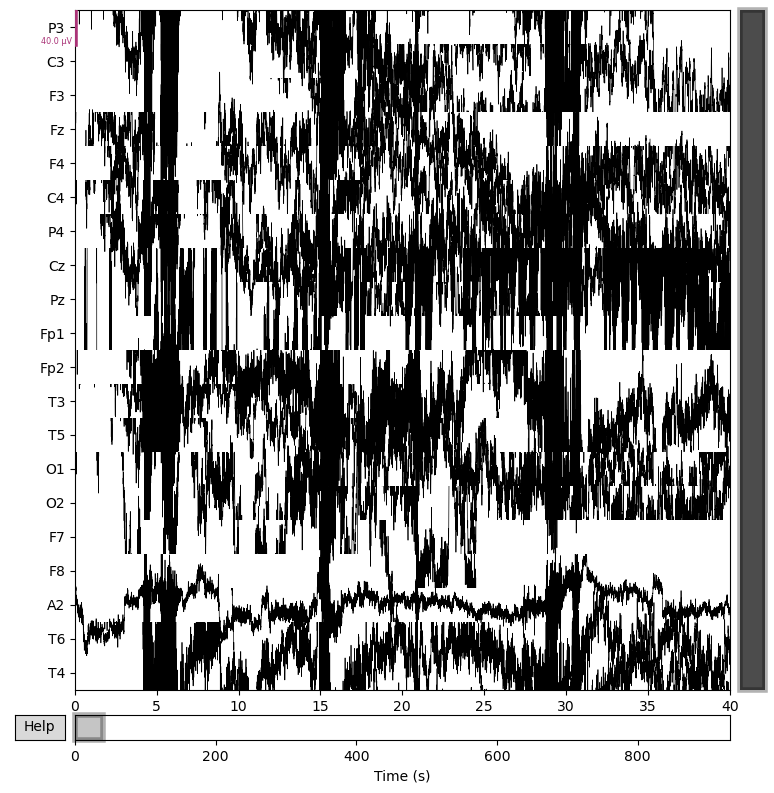

In [ ]:
clean.plot(title='Cleanish RAW', n_channels=24, duration=40)
test.plot(title="Test RAW", n_channels=24,duration=40)

## Run EEG Quality Index on RAW data

Run the EEG Quality Index on the RAW data. Notice how the tool reports that some variables have `NaN` values.

Printing the resulting matrix [EQI x channels] shows that the zero-crossing rate is the only variable with `Nan` values.

In [ ]:
# Match channel order
clean_eeg = clean.get_data()
test_eeg = test.get_data(picks=range(np.size(clean_eeg,0))) # Cut size of test_eeg to channel number in clean_eeg

# Run EQI
eqi_results = eeg_quality_index.scoring(clean_eeg, test_eeg, srate_clean=int(clean.info['sfreq']),
    srate_test=int(test.info['sfreq']), window=int(sfreq), slide=10)

print(f'\nRaw data results\n{eqi_results[2]}')

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully

Raw data results
[[0.91172359 1.18339844 1.0157342  1.1042615  1.99551987 1.64510233
  1.28533027 0.63890183 0.80864485 1.62485216 1.70094262 1.51019677
  1.37159958 1.13472635 0.48166732 1.77778574 1.90129386 0.96982187
  1.23171213 1.95716999]
 [2.31715709 2.29468478 0.6567865  1.85892979 2.05558941 1.9134798
  2.56901186 1.71803878 2.35980789 1.67710835 1.61607111 1.55711265
  1.37267481 2.08315114 1.65621304 1.70735816 1.74362926 1.15354288
  1.47231282 1.55743522]
 [1.95423103 0.66123078 0.07867102 2.29669187 2.15848894 1.70667718
  1.26518763 2.39865955 1.65148203 2.46897961 2.58116197 1.00451597
  1.90520053 1.05784739 0.87910828 2.04799111 1.8666356  0.73592344
  2.35848177 2.86283646]
 [1.35074012 1.45428479 1.17343464 1.37539873 1.71058385 1.48517974
  1.41908892 1.3813125  0.7422673  1.24551091 1.32174474 1.52829648
  1.21651554 1.60478119 1.34436042 1.19178524 1.57101896 1.26067166
  1.27955987 1.60453

d:\Users\Eli Kinney-Lang\Documents\GitHub\EEG_quality_index\Notebooks\..\Functions\eeg_quality_index.py:80: RuntimeWarning: divide by zero encountered in true_divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
d:\Users\Eli Kinney-Lang\Documents\GitHub\EEG_quality_index\Notebooks\..\Functions\eeg_quality_index.py:80: RuntimeWarning: invalid value encountered in true_divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


## Filter "clean" dataset

Now, apply a high-pass filter to the data and visualize it again. Notice how the DC-offset toggle does not do much change. This is because the high-pass filter already got rid of the DC components

In [ ]:
# Apply hihg-pass filter
filtered = clean.copy()     # Copye clean to filtered MNE object
filtered = filtered.filter(l_freq=0.1, h_freq=None)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 9901 samples (33.003 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [ ]:
test = eqi_results[2]

## Plot filtered data

Navigation tips:
- Use $+$ or $-$ to increase or decrease the vertical scale
- Use left or right arrows to control the horizontal sliding
- Use `d` to toggle DC-offset. 

Notice that with the DC-offset toggle there is no change in the signal.

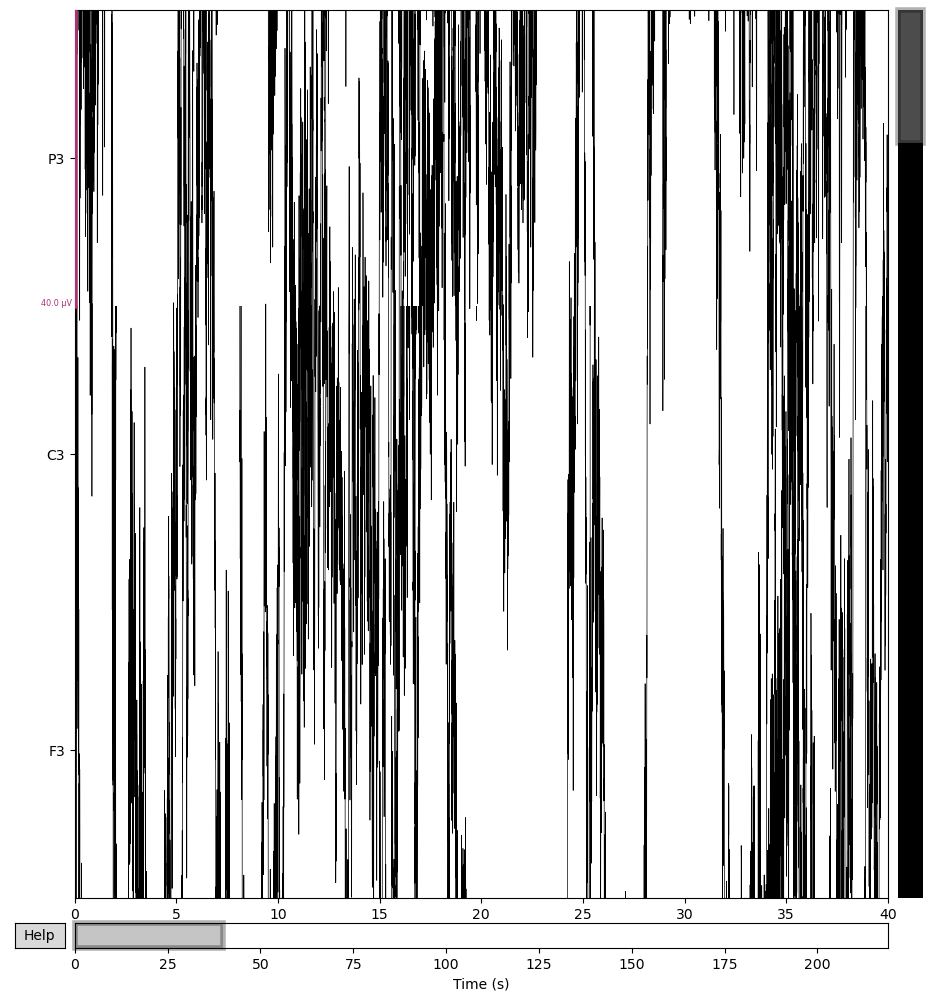

In [ ]:
filtered.plot(title='Filtered', n_channels=3, duration=40)

## Run EEG Quality Index on filtered data

In [ ]:
# Match channel order
filtered_eeg = filtered.get_data()
test_eeg = test.get_data(picks=range(np.size(filtered_eeg,0))) # Cut size of test_eeg to channel number in clean_eeg

eqi_results = eeg_quality_index.scoring(filtered_eeg, test_eeg, srate_clean=int(clean.info['sfreq']),
    srate_test=int(test.info['sfreq']), window=int(sfreq), slide=10)
# EEG Quality Index


In [ ]:
output1 = eqi_results[0]
print("Output 1 - Percentage of Summed Windows" , output1)

output2 = eqi_results[1]
print("Output 2 - Clean Percent" , output2)

output3 = eqi_results[2]
print("Output 3 - Z-score Matrix" , output3)

Output 1 - Percentage of Summed Windows [3.58410093e-03 8.96025232e-02 1.66194760e+01 1.29027633e-01
 0.00000000e+00 3.94251102e-02 0.00000000e+00 2.07877854e-01
 0.00000000e+00 1.97125551e-01 2.15046056e-02 2.40134762e+00
 0.00000000e+00 0.00000000e+00 4.98190029e-01 5.01774130e-02
 2.79559872e-01 1.12397405e+01 1.76337766e+00 0.00000000e+00]
Output 2 - Clean Percent [[57.56424501 50.33869754 56.3850758  52.87624099 23.543959   32.64757536
  41.98415827 69.72868356 60.90104297 26.46500125 27.61549765 40.64370453
  42.67588975 46.61840077 77.37715494 30.78384287 23.34683345 49.43192
  43.6471811  28.5581162 ]
 [ 8.84556109  6.08938748 68.68929429 14.64463639 15.22167664 13.66259274
   4.65574711 14.63388409  2.77051002 22.10673453 27.09221892 34.43604172
  38.93050428 14.21812838 15.50482062 31.32145801 25.8772087  46.85136733
  34.94856815 39.49679223]
 [ 7.86710154  7.67714419 39.87670693  4.39052364  0.15053224  6.73094154
   9.36883983 12.76298341 14.11060535  7.46926633  6.3976201